___
**Mood:**
- A state of mind that is not as specific as emotion
- Biases which emotions are felt (DOI:10.1080/10803548.2003.11076589)
___
**Behavioral correlates with mood include**
- Voice modulation (May have something like this through speech telephony)
- Gestures
- Cognitive performance
- Cognitive strategy
- Motor behavior (Is like errors when pressing keys?)
- (DOI:10.1080/10803548.2003.11076589)
___

**Keyboard stokes may predict future moods.**
- But it is not known over how long the data needs to be collected for prediction to be reliable
(https://doi.org/10.1016/j.asej.2021.101660)
___

**Data Available to us**
- Phone Usage
- Speech Telephony
- Keyboard Metrics
___
**Data that seems interesting**
- Total Error Distances
- Total Corrections
- Emoji Counts
- Total ScreenTime
___
**Data that can be used as labels**
- Self report survey scores
- Calculated IB Gaps
___

In [17]:
import pandas as pd
import numpy as np
import pickle
import datetime
import json
import re
import os, gzip, shutil

In [18]:
## data directory

directory = "/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/Data/"

In [19]:
## Good Subjects

# participant = "1e7aef96-16cc-43f8-95d4-e3bc582eb6d3/2017C676-C22A-4318-903C-7544760252BB/"
participant = "2baee05a-5e5a-4436-8c25-2628d46d1e08/4684F36F-66CC-4FB1-9383-3BC2B008D365/"

In [20]:
## Concerned with keyboard metric for now
metric_folder = "sensorkit-keyboard-metrics/iPhone"

___
##### Functions to unzip files in a folder
- Function will unzip all files in a given directory
___

In [21]:
## Recursively unzip everything
import fnmatch
import gzip
import shutil

def gunzip(file_path, output_path):
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

def recurse_and_gunzip(root):
    walker = os.walk(root)
    for rootx,dirs,files in walker:
        for f in files:
            if fnmatch.fnmatch(f,"*.gz"):
                gunzip(rootx+"/"+f, rootx+"/"+f.replace(".gz",""))

In [22]:

## Iterative decompression
def gz_extract(directory):
    extension = ".gz"
    os.chdir(directory)
    for item in os.listdir(directory): # loop through items in dir
      if item.endswith(extension): # check for ".gz" extension
          gz_name = os.path.abspath(item) # get full path of files
          file_name = (os.path.basename(gz_name)).rsplit('.',1)[0] #get file name for file within
          with gzip.open(gz_name,"rb") as f_in, open(file_name,"wb") as f_out:
            print(gz_name)
            shutil.copyfileobj(f_in, f_out)
          os.remove(gz_name) # delete zipped file

In [23]:
def fix_date_to_ET(end_date):
    if pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 5:
        return pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date() - datetime.timedelta(days=1)
    else:
        return pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()


def get_date_from_timestamp(timestamp):
    return pd.to_datetime(timestamp, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').date()

def get_time_from_timestamp(timestamp):
    return pd.to_datetime(timestamp, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').time()

def set_am_pm(end_date):
    if 5 < pd.to_datetime(end_date, format= '%Y-%m-%d', utc=True).tz_convert('US/Eastern').hour < 17:
        return "am"
    else:
        return "pm"

def average_corrections_am_pm_values(dataframe):

    retroDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalRetroCorrections"].mean()
    nearKeyDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalNearKeyCorrections"].mean()
    SubstitutionDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalSubstitutionCorrections"].mean()
    SpaceDF = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["totalSpaceCorrections"].mean()

    correctionsDF = retroDF
    correctionsDF = correctionsDF.merge(nearKeyDF, how='left', on=['name', 'ET_Date', 'am/pm'])
    correctionsDF = correctionsDF.merge(SubstitutionDF, how='left', on=['name', 'ET_Date', 'am/pm'])
    correctionsDF = correctionsDF.merge(SpaceDF, how='left', on=['name', 'ET_Date', 'am/pm'])

    return correctionsDF

def average_errors_am_pm_values(dataframe):

    shortCharUP = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["shortWordCharKeyUpErrorDistance"].mean()
    shortWordDown = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["shortWordCharKeyDownErrorDistance"].mean()
    spaceUP = dataframe.groupby(['name','ET_Date', 'am/pm'], as_index=False)["spaceUpErrorDistance"].mean()

    errorDF = shortCharUP
    errorDF = errorDF.merge(shortWordDown, how='left', on=['name', 'ET_Date', 'am/pm'])
    errorDF = errorDF.merge(spaceUP, how='left', on=['name', 'ET_Date', 'am/pm'])

    return errorDF


##### Each JSON File contains two dictionaries:
    - device
    - sample
________________________________________________________________________________
##### The device dictionary contains
    - name
    - phone type
________________________________________________________________________________

##### The sample dictionary has a list of samples
##### Each sample inside this list has the following variables types of interest:
    - Corrections
    - Errors
________________________________________________________________________________
1. Corrections of interest:
    - total Retro Corrections
    - total Insert Key Corrections
    - total Near Key Corrections
    - total Hit Test Corrections
    - total Substitution Corrections
________________________________________________________________________________
2. Errors of interest:
    - shortWordCharKeyUpErrorDistance
    - shortWordCharKeyDownErrorDistance
    - spaceUpErrorDistance
________________________________________________________________________________
3. Other variables of interest:
    - total Typing Episodes
    - timestamp
________________________________________________________________________________

In [24]:
## Functions for single participants
## Get data and corresponding

## Need a loop here to loop over all files in the directory
### directory = "/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/Data_20220930-20221001/sensorkit-keyboard-metrics/iPhone/1b9b62f1-095b-4819-92a0-ea8e7abee884/C4168B14-53AD-4091-97B5-7A3E4EB4A738"
## recurse_and_gunzip(directory)

correctionsList = []
errorsList = []

## Loop over all the exported data folders/directories
for folder in os.listdir(directory):
    path = directory + folder + "/" + metric_folder + "/" + participant
    gz_extract(path)

    ## print(path)
    ## Loop over all files in this path/directory
    for fname in os.listdir(path):
        
        filename = ""

        ## name of the file
        if fname.endswith("json"):
            filename = path + fname
        else: 
            continue
        
        ## Load the JSON File
        file = open(filename)
        # print(filename)
        ## Need to use json.load and not json.loads
        loaded_file = json.load(file)

        ## Get the samples list
        samples = loaded_file["samples"]

        ## Get the name
        name = loaded_file["device"]["name"]

        ## Need a loop here to iterate over all samples
        for i in range(len(samples)):

            ## Get the TimeStamp for the current sample
            timeStamp = samples[i]["timestamp"]

            ## Get the sample dictionary
            sample_dict_iterator = samples[i]["sample"]

            ## Get the variables for the current dict iterator
            totalTypingEpisodes = sample_dict_iterator["totalTypingEpisodes"]

            ## Correction variables
            correction_dict_temp = {
                "name": name,
                "timeStamp": timeStamp,
                "totalRetroCorrections": sample_dict_iterator["totalRetroCorrections"], "totalInsertKeyCorrections": sample_dict_iterator["totalInsertKeyCorrections"],
                "totalNearKeyCorrections": sample_dict_iterator["totalNearKeyCorrections"], "totalHitTestCorrections": sample_dict_iterator["totalHitTestCorrections"],
                "totalSubstitutionCorrections": sample_dict_iterator["totalSubstitutionCorrections"], "totalTranspositionCorrections": sample_dict_iterator["totalTranspositionCorrections"],
                "totalSpaceCorrections": sample_dict_iterator["totalSpaceCorrections"], "totalAutoCorrections": sample_dict_iterator["totalAutoCorrections"]
            }
            correctionsList.append(correction_dict_temp)

            ## Error variables
            ## These are distribution
            ## Taking the mean of the distribution for each sample
            shortWordCharKeyUpErrorDistance = sum(sample_dict_iterator["shortWordCharKeyUpErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["shortWordCharKeyUpErrorDistance"]["distributionSampleValues"])
            shortWordCharKeyDownErrorDistance = sum(sample_dict_iterator["shortWordCharKeyDownErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["shortWordCharKeyDownErrorDistance"]["distributionSampleValues"])
            spaceUpErrorDistance = sum(sample_dict_iterator["spaceUpErrorDistance"]["distributionSampleValues"])/len(sample_dict_iterator["spaceUpErrorDistance"]["distributionSampleValues"])

            error_dict_temp = {
                "name": name,
                "timeStamp": timeStamp,
                "shortWordCharKeyUpErrorDistance": shortWordCharKeyUpErrorDistance,
                "shortWordCharKeyDownErrorDistance": shortWordCharKeyDownErrorDistance,
                "spaceUpErrorDistance": spaceUpErrorDistance
            }
            errorsList.append(error_dict_temp)

_______________
#### Add Date, Time, and Am/Pm Column
_______________

In [25]:
correctionsDF = pd.DataFrame(correctionsList)
errorDF = pd.DataFrame(errorsList)

errorDF["ET_Date"] = errorDF.apply(lambda x: fix_date_to_ET(x.timeStamp), axis=1)
errorDF["ET_Time"] = errorDF.apply(lambda x: get_time_from_timestamp(x.timeStamp), axis=1)
errorDF["am/pm"] = errorDF.apply(lambda x: set_am_pm(x.timeStamp), axis=1) 
## errorDF.sort_values(by = "ET_Date", ascending = False).reset_index(drop=True)

correctionsDF["ET_Date"] = correctionsDF.apply(lambda x: fix_date_to_ET(x["timeStamp"]), axis=1)
correctionsDF["ET_Time"] = correctionsDF.apply(lambda x: get_time_from_timestamp(x.timeStamp), axis=1)
correctionsDF["am/pm"] = correctionsDF.apply(lambda x: set_am_pm(x.timeStamp), axis=1)
# correctionsDF.sort_values(by = "ET_Date", ascending = False).reset_index(drop=True)

In [26]:
## Get average of am and pm values
AverageCorrectionsDF = average_corrections_am_pm_values(correctionsDF)
AverageErrorDF = average_errors_am_pm_values(errorDF)

In [39]:
## Separate the am and pm dataframes
morningAverageCorrectionsDF = AverageCorrectionsDF.loc[AverageCorrectionsDF["am/pm"] == "am"].reset_index(drop=True)
eveningAverageCorrectionsDF = AverageCorrectionsDF.loc[AverageCorrectionsDF["am/pm"] == "pm"].reset_index(drop=True)
morningAverageErrorDF = AverageErrorDF.loc[AverageErrorDF["am/pm"] == "am"].reset_index(drop=True)
eveningAverageErrorDF = AverageErrorDF.loc[AverageErrorDF["am/pm"] == "pm"].reset_index(drop=True)

In [40]:
eveningAverageCorrectionsDF

,name,ET_Date,am/pm,totalRetroCorrections,totalNearKeyCorrections,totalSubstitutionCorrections,totalSpaceCorrections
0,iPhone,2022-10-04,pm,0.000000,4.000000,0.000000,0.000000
1,iPhone,2022-10-05,pm,0.068966,3.344828,0.000000,0.103448
2,iPhone,2022-10-08,pm,0.000000,5.000000,0.000000,0.000000
3,iPhone,2022-10-10,pm,0.083333,4.694444,0.000000,0.111111
4,iPhone,2022-10-11,pm,0.000000,3.666667,0.000000,0.000000
5,iPhone,2022-10-12,pm,0.108108,4.594595,0.027027,0.216216
6,iPhone,2022-10-13,pm,0.041667,4.833333,0.000000,0.125000
7,iPhone,2022-10-14,pm,0.259259,6.592593,0.000000,0.074074
8,iPhone,2022-10-16,pm,0.125000,9.125000,0.062500,0.145833
9,iPhone,2022-10-18,pm,0.135135,4.432432,0.027027,0.054054


<AxesSubplot: xlabel='spaceUpErrorDistance', ylabel='shortWordCharKeyDownErrorDistance'>

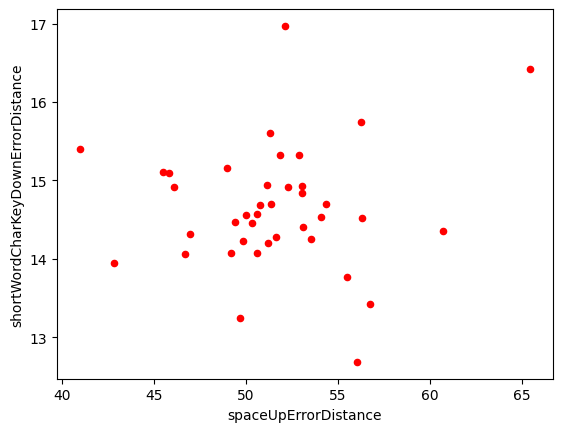

In [27]:
from sklearn import preprocessing
import numpy
from matplotlib import pyplot as plt 

temp = AverageErrorDF["spaceUpErrorDistance"].to_numpy()
# normalized_arr = preprocessing.normalize([temp])
# hist, bins = numpy.histogram(normalized_arr[0], bins=10)
# plt.hist(normalized_arr[0], bins = 10)
AverageErrorDF.plot.scatter("spaceUpErrorDistance", "shortWordCharKeyDownErrorDistance", c = 'red')

In [41]:
# ## Want to extract the keyboard metrics in a good way
# file_path = "RK.8D1DBFAD.DJW Thesis_20220930-20221001/sensorkit-keyboard-metrics/iPhone/2f32cd19-e9c5-4aad-8999-6f4646169ab6/3400296D-7399-44F9-9E9D-2CA824598AE8/2022-09-28T163510-0400_2022-09-29T071630-0400.json.gz"
# a = gzip.open(file_path, 'rb')
# contents = json.loads(a.read())
# print(pd.DataFrame(contents))
## Join the App data with this DataFrame

moodDF = pd.read_csv('/Users/farhan/DNL/BuddingScholar/Budding_Scholar_22-23/output_tables/self_report.csv')

morning_columns = [col for col in moodDF.columns if (col.endswith("am") or col in ["ParticipantIdentifier", "StudyDay"])]
evening_columns = [col for col in moodDF.columns if (col.endswith("pm") or col in ["ParticipantIdentifier", "StudyDay"])]

morningMoodDF = moodDF[morning_columns]
eveningMoodDF = moodDF[evening_columns]